In [2]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os

selected_line =['8700-10-1',
                '7545-10-1',
                '7545-10-0',   #Less two links
                '6450-10-1',
                '6450-10-0',
                '3301-10-1',   #Less two links
                '2290-10-1',
                '2290-10-0',
                '477P-10-0',        
                '3301-10-0',   #Less two links
                '574J-10-1',   #Less two links
                '574J-10-0',   #Less two links
                '477P-10-1',   #Less two links
                '351F-10-1',
                '351F-10-0'] 

selected_line = ['6450-10-0']

### Size of the steps to group
frequencies = ['20min', '30min', '1H', '3H', '1d', '7d', '1m']
frequencies = ['30min']


In [3]:
for line in selected_line:  
    filename = str(line) + '_temp.csv.gz'
    df = pd.read_csv(filename, compression='gzip', sep=',')
    df['exact_time'] = pd.to_datetime(df['exact_time'], format = '%Y-%m-%d %H:%M')
    df.index = df['exact_time']
    
    df.loc[(df['time_link'] > 5),'time_link'] = np.ceil(df['time_link'].mean())
    
    start_date = pd.to_datetime('2017-1-1', format = '%Y-%m-%d')
    end_date = pd.to_datetime('2017-9-25', format = '%Y-%m-%d')
    df = df.loc[(df['holiday'] != 1) & ((df['weekday'] > 0) & (df['weekday'] < 5))]
 
    
    frequency = '60min'            
    rolling_win = 3
    df = df.drop(df[df['link'] == max(df['link'])].index)
    if (line == '7545-10-1') | (line == '477P-10-1') | (line == '3301-10-0') | \
            (line == '3301-10-0') | (line == '574J-10-1') | (line == '574J-10-1'):
            df = df.drop(df[df['link'] == max(df['link'])].index)

    X_Temp = df.groupby([pd.Grouper(freq=str(frequency)), 'link'], as_index=True ).mean()['time_link'].unstack()    
    X_Temp = X_Temp.transform(lambda x: x.fillna(method='ffill')).dropna()
    X_Temp.describe()

### Shallow model

In [8]:
import numpy as np
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model

# https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
lam = 1e-4
def contractive_loss(y_pred, y_true):
    mse = K.mean(K.square(y_true - y_pred), axis=1)

    W = K.variable(value=autoencoder.get_layer(index=1).get_weights()[0])  # N x N_hidden
    #W = K.variable(value=autoencoder.get_layer(index=3).get_weights()[0])  # N x N_hidden
    W = K.transpose(W)  # N_hidden x N
    h = autoencoder.get_layer(index=1).output
    #h = autoencoder.get_layer(index=3).output
    dh = h * (1 - h)  # N_batch x N_hidden

    # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
    contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

    return mse + contractive

# this is the size of our encoded representations
encoding_dim = 3 
input_dim = 27

# this is our input placeholder
input_data = Input(shape=(input_dim,))
# "encoded" is the encoded representation of the input
#encoded = Dense(encoding_dim, activation='relu')(input_data)
encoded = Dense(encoding_dim, activation='sigmoid')(input_data)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='sigmoid')(encoded)
#decoded = Dense(input_dim, activation='relu')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error') #contractive_loss, binary_crossentropy, mean_squared_error


# this model maps an input to its encoded representation
encoder = Model(input_data, encoded)

encoder.summary()
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
decoder.summary()

# Creates the train and test sets 
test_samples = 500
train = X_Temp.values[:-test_samples,:-2] # two last columns have large errors
test = X_Temp.values[-test_samples:,:-2] # two last columns have large errors

#Normalize the inputs
trmin = train.min(); trmax = train.max();
temin = test.min(); temax = test.max();
train_norm = (train-trmin)/(trmax-trmin)
test_norm  = (test-temin)/(temax-temin)

print(np.shape(test_norm))
print(np.shape(train_norm))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 27)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 84        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 27)                108       
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________
(500, 27)
(2476, 27)


### Deep model

In [9]:
import keras.backend as K
import numpy as np
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model

# https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
lam = 1e-4
def contractive_loss(y_pred, y_true):
    mse = K.mean(K.square(y_true - y_pred), axis=1)

    #W = K.variable(value=autoencoder.get_layer(index=1).get_weights()[0])  # N x N_hidden
    W = K.variable(value=autoencoder.get_layer(index=3).get_weights()[0])  # N x N_hidden
    W = K.transpose(W)  # N_hidden x N
    #h = autoencoder.get_layer(index=1).output
    h = autoencoder.get_layer(index=3).output
    dh = h * (1 - h)  # N_batch x N_hidden

    # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
    contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

    return mse + contractive


# this is the size of our encoded representations
encoding_dim = 5  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
input_dim = 27

# this is our input placeholder
input_data = Input(shape=(input_dim,))
encoded1 = Dense(20, activation='relu')(input_data)
encoded2 = Dense(10, activation='relu')(encoded1)
encoded3 = Dense(encoding_dim, activation='sigmoid')(encoded2)

decoded1 = Dense(10, activation='relu')(encoded3)
decoded2 = Dense(20, activation='relu')(decoded1)
decoded3 = Dense(input_dim, activation='sigmoid')(decoded2)
#encoded1 = Dense(20, activation='sigmoid')(input_data)
#encoded2 = Dense(10, activation='sigmoid')(encoded1)
#encoded3 = Dense(encoding_dim, activation='sigmoid')(encoded2)

#decoded1 = Dense(10, activation='sigmoid')(encoded3)
#decoded2 = Dense(20, activation='sigmoid')(decoded1)
#decoded3 = Dense(input_dim, activation='sigmoid')(decoded2)


# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded3)
autoencoder.compile(optimizer='adam', loss="binary_crossentropy") #contractive_loss, binary_crossentropy, mean_squared_error


i1 = autoencoder.get_layer(index=0)
e1 = autoencoder.get_layer(index=1)
e2 = autoencoder.get_layer(index=2)
e3 = autoencoder.get_layer(index=3)

o1 = autoencoder.get_layer(index=4)
o2 = autoencoder.get_layer(index=5)
o3 = autoencoder.get_layer(index=6)

# this model maps an input to its encoded representation
encoder = Model(input_data, e3(e2(e1(input_data))))
encoder.summary()

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# create the decoder model
decoder = Model(encoded_input, o3(o2(o1(encoded_input))))

decoder.summary()
# Creates the train and test sets 
test_samples = 500
train = X_Temp.values[:-test_samples,:-2] # two last columns have large errors
test = X_Temp.values[-test_samples:,:-2] # two last columns have large errors

#Normalize the inputs
trmin = train.min(); trmax = train.max();
temin = test.min(); temax = test.max();
train_norm = (train-trmin)/(trmax-trmin)
test_norm  = (test-temin)/(temax-temin)

print(np.shape(train_norm))
print(np.shape(test_norm))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 27)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                560       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 55        
Total params: 825
Trainable params: 825
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 5)                 0         
_________________________________________________________________
dense_12 (De

### Standard Loss Function

In [11]:
#autoencoder.compile(optimizer='adam', loss='mean_squared_error') #binary_crossentropy, mean_squared_error

autoencoder.fit(train_norm, train_norm,
                epochs=5000,
                batch_size=128,
                shuffle=True,
                validation_data=(test_norm, test_norm))

Train on 2476 samples, validate on 500 samples
Epoch 1/5000
2476/2476 [==============================] - 0s 149us/step - loss: 0.6893 - val_loss: 0.6817
Epoch 2/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6821 - val_loss: 0.6697
Epoch 3/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6739 - val_loss: 0.6564
Epoch 4/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6669 - val_loss: 0.6461
Epoch 5/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6636 - val_loss: 0.6414
Epoch 6/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6626 - val_loss: 0.6401
Epoch 7/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6622 - val_loss: 0.6393
Epoch 8/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6618 - val_loss: 0.6384
Epoch 9/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6613 - val_loss: 0.6375
Epoch 1

Epoch 78/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6479 - val_loss: 0.6146
Epoch 79/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6479 - val_loss: 0.6145
Epoch 80/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6479 - val_loss: 0.6145
Epoch 81/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6479 - val_loss: 0.6145
Epoch 82/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6478 - val_loss: 0.6145
Epoch 83/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6478 - val_loss: 0.6145
Epoch 84/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6478 - val_loss: 0.6145
Epoch 85/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6478 - val_loss: 0.6145
Epoch 86/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6478 - val_loss: 0.6144
Epoch 87/5000
2476/2476 [=====================

Epoch 155/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6465 - val_loss: 0.6125
Epoch 156/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6465 - val_loss: 0.6124
Epoch 157/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6465 - val_loss: 0.6123
Epoch 158/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6465 - val_loss: 0.6123
Epoch 159/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6465 - val_loss: 0.6124
Epoch 160/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6465 - val_loss: 0.6123
Epoch 161/5000
2476/2476 [==============================] - 0s 12us/step - loss: 0.6465 - val_loss: 0.6124
Epoch 162/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6465 - val_loss: 0.6124
Epoch 163/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6465 - val_loss: 0.6123
Epoch 164/5000
2476/2476 [===========

2476/2476 [==============================] - 0s 14us/step - loss: 0.6457 - val_loss: 0.6114
Epoch 308/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 309/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6113
Epoch 310/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6114
Epoch 311/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6113
Epoch 312/5000
2476/2476 [==============================] - 0s 12us/step - loss: 0.6457 - val_loss: 0.6113
Epoch 313/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6113
Epoch 314/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6113
Epoch 315/5000
2476/2476 [==============================] - 0s 12us/step - loss: 0.6457 - val_loss: 0.6113
Epoch 316/5000
2476/2476 [==========================

2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 460/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6457 - val_loss: 0.6113
Epoch 461/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 462/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 463/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 464/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 465/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6111
Epoch 466/5000
2476/2476 [==============================] - 0s 12us/step - loss: 0.6457 - val_loss: 0.6111
Epoch 467/5000
2476/2476 [==============================] - 0s 12us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 468/5000
2476/2476 [==========================

2476/2476 [==============================] - 0s 15us/step - loss: 0.6457 - val_loss: 0.6111
Epoch 612/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 613/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 614/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6113
Epoch 615/5000
2476/2476 [==============================] - 0s 12us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 616/5000
2476/2476 [==============================] - 0s 12us/step - loss: 0.6457 - val_loss: 0.6111
Epoch 617/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 618/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6111
Epoch 619/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 620/5000
2476/2476 [==========================

2476/2476 [==============================] - 0s 16us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 764/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 765/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6111
Epoch 766/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6457 - val_loss: 0.6113
Epoch 767/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 768/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6457 - val_loss: 0.6111
Epoch 769/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 770/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 771/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 772/5000
2476/2476 [==========================

2476/2476 [==============================] - 0s 14us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 916/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 917/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6457 - val_loss: 0.6113
Epoch 918/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6457 - val_loss: 0.6113
Epoch 919/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 920/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 921/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6457 - val_loss: 0.6111
Epoch 922/5000
2476/2476 [==============================] - 0s 13us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 923/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 924/5000
2476/2476 [==========================

2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1068/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1069/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 1070/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1071/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1072/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6111
Epoch 1073/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 1074/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6457 - val_loss: 0.6112
Epoch 1075/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6457 - val_loss: 0.6111
Epoch 1076/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6111
Epoch 1144/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1145/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1146/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1147/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1148/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1149/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6456 - val_loss: 0.6111
Epoch 1150/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1151/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1152/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1220/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1221/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1222/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1223/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1224/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6111
Epoch 1225/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6111
Epoch 1226/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1227/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1228/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 18us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1296/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1297/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1298/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1299/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1300/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1301/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1302/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1303/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1304/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1372/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1373/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1374/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1375/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6111
Epoch 1376/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1377/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1378/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1379/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6111
Epoch 1380/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 27us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1448/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1449/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1450/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1451/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1452/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1453/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1454/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6456 - val_loss: 0.6112
Epoch 1455/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6456 - val_loss: 0.6113
Epoch 1456/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 16us/step - loss: 0.6452 - val_loss: 0.6105
Epoch 1524/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6452 - val_loss: 0.6105
Epoch 1525/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6452 - val_loss: 0.6105
Epoch 1526/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6452 - val_loss: 0.6105
Epoch 1527/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6452 - val_loss: 0.6106
Epoch 1528/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6452 - val_loss: 0.6106
Epoch 1529/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6452 - val_loss: 0.6105
Epoch 1530/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6452 - val_loss: 0.6107
Epoch 1531/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6452 - val_loss: 0.6105
Epoch 1532/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 15us/step - loss: 0.6449 - val_loss: 0.6104
Epoch 1600/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6449 - val_loss: 0.6104
Epoch 1601/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6449 - val_loss: 0.6104
Epoch 1602/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6449 - val_loss: 0.6105
Epoch 1603/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6449 - val_loss: 0.6105
Epoch 1604/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6449 - val_loss: 0.6104
Epoch 1605/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6449 - val_loss: 0.6103
Epoch 1606/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6449 - val_loss: 0.6104
Epoch 1607/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6449 - val_loss: 0.6103
Epoch 1608/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 16us/step - loss: 0.6449 - val_loss: 0.6102
Epoch 1676/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6449 - val_loss: 0.6103
Epoch 1677/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6449 - val_loss: 0.6103
Epoch 1678/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6449 - val_loss: 0.6103
Epoch 1679/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6449 - val_loss: 0.6102
Epoch 1680/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1681/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 1682/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6449 - val_loss: 0.6104
Epoch 1683/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6449 - val_loss: 0.6103
Epoch 1684/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1752/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1753/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 1754/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1755/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1756/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 1757/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1758/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1759/5000
2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1760/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1828/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1829/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1830/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1831/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1832/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1833/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 1834/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1835/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1836/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1904/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1905/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1906/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1907/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1908/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1909/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1910/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1911/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1912/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1980/5000
2476/2476 [==============================] - 0s 23us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1981/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1982/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1983/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1984/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1985/5000
2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 1986/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1987/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 1988/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2056/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2057/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2058/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2059/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2060/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2061/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2062/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2063/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2064/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2132/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2133/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2134/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2135/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2136/5000
2476/2476 [==============================] - 0s 23us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2137/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2138/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2139/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2140/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2208/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2209/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2210/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2211/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2212/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2213/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2214/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2215/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6100
Epoch 2216/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2284/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2285/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2286/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2287/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6100
Epoch 2288/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 2289/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2290/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2291/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2292/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2360/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6100
Epoch 2361/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2362/5000
2476/2476 [==============================] - 0s 14us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2363/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2364/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2365/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6100
Epoch 2366/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2367/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2368/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2436/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2437/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2438/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 2439/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2440/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2441/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2442/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2443/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2444/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2512/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2513/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2514/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2515/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2516/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2517/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2518/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2519/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2520/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2588/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2589/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2590/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2591/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2592/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2593/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2594/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 2595/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 2596/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2664/5000
2476/2476 [==============================] - 0s 27us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2665/5000
2476/2476 [==============================] - 0s 24us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2666/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2667/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2668/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2669/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2670/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2671/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6100
Epoch 2672/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2740/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2741/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2742/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2743/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2744/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2745/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2746/5000
2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2747/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2748/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2816/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2817/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2818/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2819/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2820/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2821/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2822/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2823/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2824/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 2892/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2893/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2894/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2895/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2896/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2897/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2898/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2899/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2900/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2968/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2969/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2970/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2971/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2972/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2973/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2974/5000
2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 2975/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 2976/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3044/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3045/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3046/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 3047/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3048/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3049/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3050/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3051/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3052/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3120/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3121/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 3122/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3123/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 3124/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3125/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3126/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3127/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3128/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3196/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3197/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3198/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3199/5000
2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3200/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3201/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3202/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3203/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3204/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3272/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3273/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 3274/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3275/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3276/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3277/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3278/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3279/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3280/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3348/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3349/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3350/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3351/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3352/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3353/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3354/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3355/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3356/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3424/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3425/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3426/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3427/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3428/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3429/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3430/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3431/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3432/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 22us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3500/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3501/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3502/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3503/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 3504/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3505/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3506/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3507/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3508/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3576/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3577/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3578/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3579/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3580/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3581/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3582/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3583/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3584/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3652/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 3653/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3654/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3655/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 3656/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3657/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3658/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 3659/5000
2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3660/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3728/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3729/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 3730/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 3731/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3732/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3733/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3734/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3735/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3736/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 23us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 3804/5000
2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3805/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3806/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3807/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3808/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3809/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3810/5000
2476/2476 [==============================] - 0s 22us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3811/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3812/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3880/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3881/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3882/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3883/5000
2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3884/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3885/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3886/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3887/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 3888/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 3956/5000
2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3957/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3958/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3959/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3960/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 3961/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6100
Epoch 3962/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3963/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 3964/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4032/5000
2476/2476 [==============================] - 0s 22us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4033/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4034/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 4035/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4036/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4037/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4038/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4039/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4040/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4108/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4109/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4110/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4111/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4112/5000
2476/2476 [==============================] - 0s 23us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4113/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4114/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4115/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4116/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4184/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4185/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4186/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4187/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4188/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4189/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4190/5000
2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4191/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 4192/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4260/5000
2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6100
Epoch 4261/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4262/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4263/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4264/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4265/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4266/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4267/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4268/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4336/5000
2476/2476 [==============================] - 0s 44us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4337/5000
2476/2476 [==============================] - 0s 22us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4338/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4339/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4340/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4341/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4342/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4343/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4344/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 22us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4412/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4413/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4414/5000
2476/2476 [==============================] - 0s 23us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4415/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4416/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4417/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4418/5000
2476/2476 [==============================] - 0s 25us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4419/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4420/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4488/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4489/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4490/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4491/5000
2476/2476 [==============================] - 0s 15us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4492/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4493/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4494/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4495/5000
2476/2476 [==============================] - 0s 23us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 4496/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 23us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4564/5000
2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4565/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4566/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4567/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4568/5000
2476/2476 [==============================] - 0s 22us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4569/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4570/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4571/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4572/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4640/5000
2476/2476 [==============================] - 0s 23us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4641/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4642/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4643/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4644/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4645/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4646/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4647/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4648/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4716/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4717/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4718/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4719/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4720/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 4721/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4722/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4723/5000
2476/2476 [==============================] - 0s 16us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4724/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4792/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4793/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4794/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4795/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4796/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4797/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4798/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4799/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4800/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 22us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4868/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4869/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4870/5000
2476/2476 [==============================] - 0s 22us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4871/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4872/5000
2476/2476 [==============================] - 0s 20us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4873/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4874/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4875/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4876/5000
2476/2476 [=================

2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4944/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6103
Epoch 4945/5000
2476/2476 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4946/5000
2476/2476 [==============================] - 0s 21us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4947/5000
2476/2476 [==============================] - 0s 17us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4948/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4949/5000
2476/2476 [==============================] - 0s 22us/step - loss: 0.6448 - val_loss: 0.6102
Epoch 4950/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4951/5000
2476/2476 [==============================] - 0s 18us/step - loss: 0.6448 - val_loss: 0.6101
Epoch 4952/5000
2476/2476 [=================

### Evaluate errors

In [12]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

encoded_states = encoder.predict(test_norm)
print(np.shape(encoded_states))

decoded_states = decoder.predict(encoded_states)
print(np.shape(decoded_states))
#decoded_states = autoencoder.predict(test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

decoded_states = decoded_states *(temax-temin)+temin
print(mean_absolute_error(decoded_states, test)/test.mean())

errors_pd = pd.DataFrame((decoded_states-test)/test)
errors_pd.describe()

#pd.DataFrame(test_orig).describe()

(500, 5)
(500, 27)
0.06907474596776385


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.001942,0.080819,0.168412,0.020302,0.000281,-0.047107,-0.016402,0.148565,0.112879,0.145185,...,0.005146,-0.030642,0.022279,0.025931,0.009163,0.013194,0.034308,0.015178,-0.030278,0.204175
std,0.071141,0.066181,0.073973,0.044830,0.047014,0.046045,0.044355,0.081150,0.073409,0.075782,...,0.075215,0.059490,0.066757,0.073357,0.088916,0.079269,0.116160,0.130274,0.087482,0.182615
min,-0.222108,-0.204581,-0.142245,-0.117379,-0.196656,-0.198126,-0.149648,-0.223748,-0.259359,-0.150007,...,-0.315228,-0.190355,-0.325164,-0.328625,-0.297224,-0.298661,-0.348217,-0.298908,-0.303880,-0.329070
25%,-0.041504,0.051164,0.130859,-0.002563,-0.023615,-0.071186,-0.043387,0.106300,0.069828,0.100861,...,-0.026758,-0.059483,-0.005811,-0.009620,-0.042179,-0.027930,-0.029454,-0.056236,-0.087525,0.108184
50%,-0.005381,0.082465,0.159604,0.019110,-0.003531,-0.050710,-0.019761,0.133837,0.100537,0.130574,...,0.001579,-0.038118,0.025559,0.028686,-0.000942,0.010799,0.027153,-0.003498,-0.035422,0.180996
75%,0.036623,0.113780,0.198290,0.037717,0.018117,-0.028653,0.003874,0.177152,0.137544,0.174216,...,0.033751,-0.015699,0.051606,0.063713,0.042903,0.049476,0.080817,0.058690,0.025643,0.276744
max,0.439425,0.480615,0.637794,0.397147,0.326070,0.291741,0.240707,0.529997,0.454998,0.535483,...,0.724911,0.469392,0.771241,0.445720,0.445627,0.506410,0.752942,0.995320,0.318552,1.405492


### Evaluate covariances between test, encoded and decoded

,t,d,e
t,1.000000,0.982593,0.910842
d,0.982593,1.000000,0.919822
e,0.910842,0.919822,1.000000


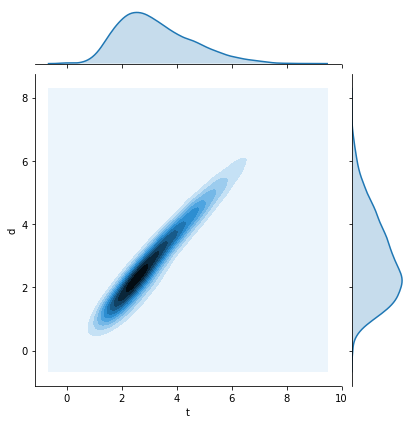

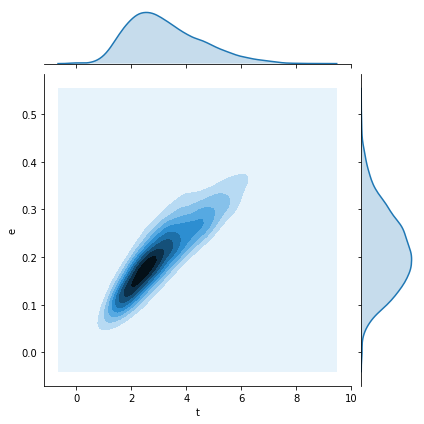

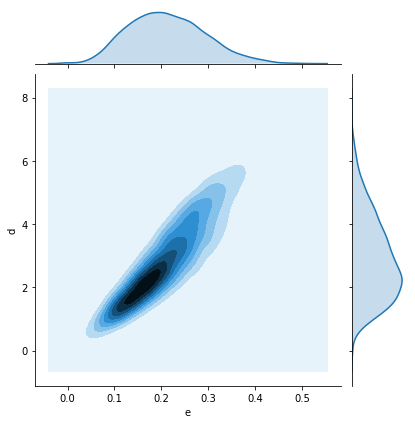

In [203]:
import seaborn as sns
import sklearn.metrics as metrics

dist_t = metrics.pairwise.euclidean_distances(test_orig)
dist_e = metrics.pairwise.euclidean_distances(encoded_states)
dist_d = metrics.pairwise.euclidean_distances(decoded_states)

df = pd.DataFrame([dist_t.flatten(), dist_d.flatten(), dist_e.flatten()]).transpose()
df.columns = ['t','d','e']

df_s = df.sample(10000)
df_s.describe()

#sns.jointplot(x="t", y="d", data=df_s); 
#sns.jointplot(x="t", y="e", data=df_s);
#sns.jointplot(x="e", y="d", data=df_s);
sns.jointplot(x="t", y="d", data=df_s, kind="kde")
sns.jointplot(x="t", y="e", data=df_s, kind="kde")
sns.jointplot(x="e", y="d", data=df_s, kind="kde")

df.corr()

### Construct Network to Predict Next state using a Neural Network

In [388]:
import numpy as np
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model

nn_input_dim = 5*3
nn_output_dim = 5

nn_input_data = Input(shape=(nn_input_dim,))
layer1 = Dense(20, activation='relu')(nn_input_data)
layer2 = Dense(10, activation='relu')(layer1)
layer3 = Dense(nn_output_dim, activation='sigmoid')(layer2)

# this model maps an input to its reconstruction
nn = Model(nn_input_data, layer3)

# Creates the train and test sets 
test_samples = 500
enc_train = encoder.predict(train)
enc_test  = encoder.predict(test)
train_X_enc = np.concatenate([enc_train[:-3], np.roll(enc_train,-1,axis=0)[:-3], np.roll(enc_train,-2,axis=0)[:-3]], axis=1)
train_Y_enc = np.roll(enc_train,-3,axis=0)[:-3]
test_X_enc  = np.concatenate([enc_test[:-3],  np.roll(enc_test,-1,axis=0)[:-3],  np.roll(enc_test,-2,axis=0)[:-3]],  axis=1)
test_Y_enc  = np.roll(enc_test,-3,axis=0)[:-3]

#Normalize the inputs
nn_trmin = train_X_enc.min(); nn_trmax = train_X_enc.max();
nn_temin = test_X_enc.min(); nn_temax = test_X_enc.max();
train_X = (train_X_enc-nn_trmin)/(nn_trmax-nn_trmin)
test_X  = (test_X_enc -nn_temin)/(nn_temax-nn_temin)
train_Y = (train_Y_enc-nn_trmin)/(nn_trmax-nn_trmin)
test_Y  = (test_Y_enc -nn_temin)/(nn_temax-nn_temin) 

print(test_X)
print(test_Y)

print (train_X.shape)
print (train_Y.shape)
print (test_X.shape)
print (test_Y.shape)

[[0.6541527  0.         0.         ... 0.         0.20825791 0.5410682 ]
 [0.5526397  0.         0.         ... 0.         0.17026134 0.55306596]
 [0.40304416 0.         0.         ... 0.         0.10977944 0.4684498 ]
 ...
 [0.5335585  0.         0.         ... 0.         0.56122833 0.92485845]
 [0.52210635 0.         0.         ... 0.         0.45998144 0.7949866 ]
 [0.52169627 0.         0.         ... 0.         0.36945423 0.73131484]]
[[0.44884816 0.         0.         0.17026134 0.55306596]
 [0.38591358 0.         0.         0.10977944 0.4684498 ]
 [0.24746186 0.         0.         0.05624629 0.49075213]
 ...
 [0.43817535 0.         0.         0.45998144 0.7949866 ]
 [0.40437758 0.         0.         0.36945423 0.73131484]
 [0.35163584 0.         0.         0.20326234 0.47120985]]
(2473, 15)
(2473, 5)
(497, 15)
(497, 5)


### Train the network

In [389]:
nn.compile(optimizer='adam', loss='binary_crossentropy') #mean_squared_error

nn.fit(train_X, train_Y,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(test_X, test_Y))

Train on 2473 samples, validate on 497 samples
Epoch 1/200
2473/2473 [==============================] - 3s 1ms/step - loss: 0.6574 - val_loss: 0.6430
Epoch 2/200
2473/2473 [==============================] - 0s 18us/step - loss: 0.6177 - val_loss: 0.6009
Epoch 3/200
2473/2473 [==============================] - 0s 22us/step - loss: 0.5728 - val_loss: 0.5566
Epoch 4/200
2473/2473 [==============================] - 0s 28us/step - loss: 0.5313 - val_loss: 0.5175
Epoch 5/200
2473/2473 [==============================] - 0s 28us/step - loss: 0.4966 - val_loss: 0.4839
Epoch 6/200
2473/2473 [==============================] - 0s 25us/step - loss: 0.4669 - val_loss: 0.4527
Epoch 7/200
2473/2473 [==============================] - 0s 27us/step - loss: 0.4383 - val_loss: 0.4233
Epoch 8/200
2473/2473 [==============================] - 0s 27us/step - loss: 0.4178 - val_loss: 0.4065
Epoch 9/200
2473/2473 [==============================] - 0s 25us/step - loss: 0.4067 - val_loss: 0.4000
Epoch 10/200
2473/

2473/2473 [==============================] - 0s 24us/step - loss: 0.3861 - val_loss: 0.3756
Epoch 156/200
2473/2473 [==============================] - 0s 23us/step - loss: 0.3861 - val_loss: 0.3756
Epoch 157/200
2473/2473 [==============================] - 0s 28us/step - loss: 0.3861 - val_loss: 0.3760
Epoch 158/200
2473/2473 [==============================] - 0s 23us/step - loss: 0.3861 - val_loss: 0.3759
Epoch 159/200
2473/2473 [==============================] - 0s 27us/step - loss: 0.3861 - val_loss: 0.3756
Epoch 160/200
2473/2473 [==============================] - 0s 44us/step - loss: 0.3861 - val_loss: 0.3757
Epoch 161/200
2473/2473 [==============================] - 0s 41us/step - loss: 0.3861 - val_loss: 0.3755
Epoch 162/200
2473/2473 [==============================] - 0s 26us/step - loss: 0.3861 - val_loss: 0.3756
Epoch 163/200
2473/2473 [==============================] - 0s 27us/step - loss: 0.3860 - val_loss: 0.3757
Epoch 164/200
2473/2473 [==============================] - 0

### Check prediction errors over encoded states

In [7]:
predicted_Y = nn.predict(test_X)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(mean_absolute_error(predicted_Y, test_Y)/test_Y.mean())

errors = (predicted_Y-test_Y)
errors_pd = pd.DataFrame(errors)
errors_pd.describe()

NameError: name 'nn' is not defined

### Test prediction over decoded states

In [405]:
predicted_Y = nn.predict(test_X)
predicted_Y_enc = predicted_Y*(nn_temax-nn_temin)+nn_temin
decoded_states = decoder.predict(predicted_Y_enc)
correct_states = np.roll(test,-3, axis=0)[:-3] # decoder.predict(test_Y)


decoded_states = decoded_states *(temax-temin)+temin
correct_states = correct_states *(temax-temin)+temin

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(decoded_states, correct_states)/correct_states.mean())

errors = (decoded_states-correct_states)/correct_states.mean()
errors_pd = pd.DataFrame(errors)
errors_pd.describe()

0.13392803486980961


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
count,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,...,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000
mean,0.049350,0.108166,0.134247,0.065961,0.055946,0.022912,0.038176,0.116032,0.104094,0.120461,...,0.091757,0.066730,0.092277,0.086401,0.024864,-0.016431,-0.004131,0.017967,0.009341,0.171986
std,0.192892,0.121042,0.088697,0.124716,0.126562,0.136684,0.121793,0.079557,0.084171,0.074105,...,0.144585,0.156431,0.153720,0.154592,0.187766,0.204216,0.220264,0.209439,0.208846,0.122585
min,-0.572806,-0.501984,-0.331679,-0.414442,-0.458532,-0.376970,-0.382836,-0.385216,-0.468820,-0.250274,...,-0.812050,-0.396092,-0.608893,-0.496822,-1.088771,-0.685387,-0.978866,-0.561555,-0.900996,-0.699289
25%,-0.077616,0.042962,0.084987,-0.003211,-0.023724,-0.076306,-0.045657,0.067810,0.054415,0.075381,...,0.021950,-0.024463,0.018059,0.013918,-0.088716,-0.128843,-0.131575,-0.139535,-0.111109,0.123891
50%,0.063793,0.120180,0.141626,0.077487,0.066980,0.027447,0.044497,0.121521,0.109622,0.126214,...,0.104152,0.071206,0.105948,0.096918,0.021972,-0.014433,0.010352,0.034152,0.027381,0.184508
75%,0.173449,0.188548,0.192902,0.145903,0.140803,0.109105,0.120818,0.164829,0.158857,0.167368,...,0.184824,0.167190,0.184563,0.177816,0.150419,0.110796,0.134958,0.162641,0.158485,0.234017
max,0.634478,0.432734,0.371450,0.435395,0.449190,0.483325,0.383339,0.333397,0.341986,0.339355,...,0.539144,0.605381,0.443651,0.524997,0.692019,0.747956,0.568443,0.591020,0.464080,0.506528


### Simple prediction of the next state just copying the last values

In [413]:
decoded_states = test[:-3]
correct_states = np.roll(test,-1, axis=0)[:-3]

decoded_states = decoded_states *(temax-temin)+temin
correct_states = correct_states *(temax-temin)+temin

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(decoded_states, correct_states)/correct_states.mean())

errors = (decoded_states-correct_states)/correct_states.mean()
errors_pd = pd.DataFrame(errors)
errors_pd.describe()

0.12312602196850445


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
count,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,4.970000e+02,497.000000,...,497.000000,497.000000,497.000000,497.000000,497.000000,4.970000e+02,4.970000e+02,497.000000,497.000000,497.000000
mean,-0.000246,-0.000131,-0.000091,-0.000120,-0.000103,-0.000092,-0.000056,-0.000024,-3.895838e-07,0.000003,...,0.000946,0.000935,0.001018,0.001333,-0.001297,1.898772e-18,-5.584623e-19,-0.000337,0.000400,0.000581
std,0.235683,0.137554,0.097486,0.135747,0.140969,0.150854,0.133579,0.087857,9.530566e-02,0.083555,...,0.167112,0.189543,0.192099,0.195143,0.250758,2.550267e-01,2.740666e-01,0.268911,0.264637,0.154123
min,-0.895979,-0.606547,-0.449884,-0.482310,-0.540596,-0.569263,-0.471502,-0.366369,-3.644039e-01,-0.294647,...,-0.810896,-0.623137,-0.688943,-0.686614,-1.216694,-7.813187e-01,-1.077707e+00,-0.931459,-1.168973,-0.847570
25%,-0.130022,-0.076105,-0.049151,-0.072028,-0.074656,-0.085363,-0.071986,-0.044233,-4.719282e-02,-0.044121,...,-0.095629,-0.118375,-0.103382,-0.117865,-0.164895,-1.605270e-01,-1.617198e-01,-0.172134,-0.139701,-0.070846
50%,0.000000,0.000011,0.002433,0.000000,0.003437,0.000000,0.001075,0.000000,0.000000e+00,0.003634,...,0.000000,0.006242,0.000000,0.009929,0.000000,-4.381333e-03,0.000000e+00,0.000000,0.004160,0.000000
75%,0.145274,0.076112,0.056336,0.079813,0.082564,0.097691,0.082573,0.052004,5.473175e-02,0.049829,...,0.092606,0.116458,0.110599,0.114809,0.159794,1.292033e-01,1.468781e-01,0.140994,0.150773,0.068045
max,0.998367,0.580563,0.525835,0.580598,0.593501,0.423454,0.542129,0.596480,5.936242e-01,0.304493,...,0.764456,0.790485,0.944504,0.753967,0.777060,1.115467e+00,1.159723e+00,0.928865,0.855666,0.851365
